In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import onnxruntime as ort
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

from segment_anything import sam_model_registry
from segment_anything import SamPredictor

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from copy import deepcopy

import warnings

## Decompose and Convert into ONNX

In [132]:
sam_checkpoint = "models/sam_vit_b.pth"
model_type = "vit_b"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

### Convert Image Encoder to ONNX

In [3]:
image_encoder = sam.image_encoder
torch.save(image_encoder.state_dict(), "/workspace/AIC/SAM/models/image_encoder.pth")

In [4]:
from segment_anything.modeling import ImageEncoderViT
from functools import partial
import torch

encoder_embed_dim=768
encoder_depth=12
encoder_num_heads=12
encoder_global_attn_indexes=[2, 5, 8, 11]
prompt_embed_dim = 256
image_size = 1024
vit_patch_size = 16
image_embedding_size = image_size // vit_patch_size
        
image_encoder = ImageEncoderViT(
    depth=encoder_depth,
    embed_dim=encoder_embed_dim,
    img_size=image_size,
    mlp_ratio=4,
    norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
    num_heads=encoder_num_heads,
    patch_size=vit_patch_size,
    qkv_bias=True,
    use_rel_pos=True,
    global_attn_indexes=encoder_global_attn_indexes,
    window_size=14,
    out_chans=prompt_embed_dim,
)
image_encoder.load_state_dict(torch.load("/workspace/AIC/SAM/models/image_encoder.pth"))

<All keys matched successfully>

In [5]:
trace_input = torch.randn(1, 3, 1024, 1024)
path = "/workspace/AIC/SAM/model_repo/image_encoder/1"
os.makedirs(path, exist_ok=True)
dynamic_batching = True

torch.onnx.export (
    image_encoder, trace_input, os.path.join(path, "model.onnx"), export_params=True, 
    input_names = ['input'], output_names = ['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

### Convert Prompt Encoder to ONNX

In [188]:
image = cv2.imread('samples/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_size = (image.shape[0], image.shape[1])

In [189]:
@staticmethod
def get_preprocess_shape(oldh: int, oldw: int, target_length: int) -> Tuple[int, int]:
    scale = target_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def apply_coords(coords: np.ndarray, original_size: Tuple[int, ...], target_length: int) -> np.ndarray:
    old_h, old_w = original_size
    new_h, new_w = get_preprocess_shape(original_size[0], original_size[1], target_length)
    coords = deepcopy(coords).astype(float)
    coords[..., 0] = coords[..., 0] * (new_w / old_w)
    coords[..., 1] = coords[..., 1] * (new_h / old_h)
    return coords

def preprocessing_prompt_encoder(
    input_point: np.ndarray, 
    input_label: np.ndarray, 
    original_size: Tuple[int, ...],
    target_length: int = 1024
):
    input_point = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
    point_labels = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
    point_coords = apply_coords(input_point, original_size, target_length).astype(np.float32)
    return point_coords, point_labels

input_point = np.array([[900, 600], [900, 600]])
input_label = np.array([1, 1])
point_coords, point_labels = preprocessing_prompt_encoder(input_point, input_label, original_size, 1024)
input_mask = np.zeros((1, 1, 256, 256), dtype=np.float32)
has_input_mask = np.zeros(1, dtype=np.float32)

In [190]:
class PromptEncoder(nn.Module):
    def __init__(self, sam):
        super().__init__()
        self.sam = sam
        self.img_size = sam.image_encoder.img_size
        
    def embed_points(self, point_coords: torch.Tensor, point_labels: torch.Tensor) -> torch.Tensor:
        point_coords = point_coords + 0.5
        point_coords = point_coords / self.img_size
        point_embedding = self.sam.prompt_encoder.pe_layer._pe_encoding(point_coords)
        point_labels = point_labels.unsqueeze(-1).expand_as(point_embedding)
        point_embedding = point_embedding * (point_labels != -1)
        point_embedding = point_embedding + self.sam.prompt_encoder.not_a_point_embed.weight * (point_labels == -1)
        for i in range(self.sam.prompt_encoder.num_point_embeddings):
            point_embedding = point_embedding + self.sam.prompt_encoder.point_embeddings[i].weight * (point_labels == i)
        return point_embedding
    
    def embed_masks(self, input_mask: torch.Tensor, has_input_mask: torch.Tensor) -> torch.Tensor:
        mask_embedding = has_input_mask * self.sam.prompt_encoder.mask_downscaling(input_mask)
        mask_embedding = mask_embedding + (1 - has_input_mask) * self.sam.prompt_encoder.no_mask_embed.weight.reshape(1, -1, 1, 1)
        return mask_embedding
        
    @torch.no_grad()
    def forward(self,
        point_coords: torch.Tensor,
        point_labels: torch.Tensor,
        input_mask: torch.Tensor,
        has_input_mask: torch.Tensor
    ):
        sparse_embedding = self.embed_points(point_coords, point_labels)
        dense_embedding = self.embed_masks(input_mask, has_input_mask)
        return sparse_embedding, dense_embedding

In [191]:
point_coords = torch.tensor(point_coords)
point_labels = torch.tensor(point_labels)
input_mask = torch.tensor(input_mask)
has_input_mask = torch.tensor(has_input_mask)

In [192]:
prompt_encoder = PromptEncoder(sam=sam)
sparse_embedding, dense_embedding = prompt_encoder(point_coords, point_labels, input_mask, has_input_mask)
sparse_embedding.shape, dense_embedding.shape

(torch.Size([1, 3, 256]), torch.Size([1, 256, 64, 64]))

In [194]:
prompt_encoder_onnx_path = "/workspace/AIC/SAM/model_repo/prompt_encoder/1"
dynamic_axes = {
    "point_coords": {1: "num_points", 0: "batch_size"},
    "point_labels": {1: "num_points", 0: "batch_size"},
    "input_mask": {0: "batch_size"},
    
    "sparse_embedding": {1: "num_points", 0: "batch_size"},
    "dense_embedding": {0: "batch_size"}
}
inputs = {
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "input_mask": torch.randn(1, 1, *[256, 256], dtype=torch.float),
    "has_input_mask": torch.tensor([1], dtype=torch.float),
}
output_names = ["sparse_embedding", "dense_embedding"]

torch.onnx.export(
    prompt_encoder,
    tuple(inputs.values()),
    os.path.join(prompt_encoder_onnx_path, "model.onnx"),
    export_params=True,
    verbose=False,
    opset_version=17,
    do_constant_folding=True,
    input_names=list(inputs.keys()),
    output_names=output_names,
    dynamic_axes=dynamic_axes,
)

### Convert Mask Decoder to ONNX

In [195]:
class MaskDecoder(nn.Module):
    def __init__(self, sam):
        super().__init__()
        self.image_pe = sam.prompt_encoder.get_dense_pe()
        self.iou_token = sam.mask_decoder.iou_token
        self.mask_tokens = sam.mask_decoder.mask_tokens
        self.transformer = sam.mask_decoder.transformer
        self.num_mask_tokens = sam.mask_decoder.num_mask_tokens
        self.output_upscaling = sam.mask_decoder.output_upscaling
        self.output_hypernetworks_mlps = sam.mask_decoder.output_hypernetworks_mlps
        self.iou_prediction_head = sam.mask_decoder.iou_prediction_head
    
    def predict_masks(self,
        image_embedding: torch.Tensor,
        sparse_embedding: torch.Tensor,
        dense_embedding: torch.Tensor
    ):
        # Concatenate output tokens
        output_tokens = torch.cat([self.iou_token.weight, self.mask_tokens.weight], dim=0)
        output_tokens = output_tokens.unsqueeze(0).expand(sparse_embedding.size(0), -1, -1)
        tokens = torch.cat((output_tokens, sparse_embedding), dim=1)
        
        # Expand per-image data in batch direction to be per-mask
        src = torch.repeat_interleave(image_embedding, tokens.shape[0], dim=0)
        src = src + dense_embedding
        pos_src = torch.repeat_interleave(self.image_pe, tokens.shape[0], dim=0)
        b, c, h, w = src.shape
        
        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]
        
        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w)
        upscaled_embedding = self.output_upscaling(src)
        hyper_in_list: List[torch.Tensor] = []
        
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
            
        hyper_in = torch.stack(hyper_in_list, dim=1)
        b, c, h, w = upscaled_embedding.shape
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w)).view(b, -1, h, w)
        
        iou_pred = self.iou_prediction_head(iou_token_out)
        return masks, iou_pred
    
    def forward(self,
        image_embedding: torch.Tensor,
        sparse_embedding: torch.Tensor,
        dense_embedding: torch.Tensor
    ):
        masks, scores = self.predict_masks(
            image_embedding=image_embedding,
            sparse_embedding=sparse_embedding,
            dense_embedding=dense_embedding
        )
        return masks, scores

In [196]:
image_embedding = torch.randn(1, 256, 64, 64)
mask_decoder = MaskDecoder(sam=sam)
masks, scores = mask_decoder(
    image_embedding=image_embedding,
    sparse_embedding=sparse_embedding,
    dense_embedding=dense_embedding
)
masks.shape, scores.shape

(torch.Size([1, 4, 256, 256]), torch.Size([1, 4]))

In [197]:
# torch
masks_input = torch.randn(1, 4, 256, 256).to(torch.float32)
score_input = torch.randn(1, 4).to(torch.float32)
point_coords = torch.randn(1, 2, 2).to(torch.float32)

def resize_longest_image_size(input_image_size: torch.Tensor, longest_side: int) -> torch.Tensor:
    input_image_size = input_image_size.to(torch.float32)
    scale = longest_side / torch.max(input_image_size)
    transformed_size = scale * input_image_size
    transformed_size = torch.floor(transformed_size + 0.5).to(torch.int64)
    return transformed_size

def select_masks(masks: torch.Tensor, scores: torch.Tensor, num_points: int) -> Tuple[torch.Tensor, torch.Tensor]:
    score_reweight = torch.tensor([[1000] + [0] * (3)])
    score = scores + (num_points - 2.5) * score_reweight
    best_idx = torch.argmax(score, dim=1)
    masks = masks[torch.arange(masks.shape[0]), best_idx, :, :].unsqueeze(1)
    scores = scores[torch.arange(masks.shape[0]), best_idx].unsqueeze(1)
    return masks, scores
    
def postprocessing(masks: torch.Tensor, orig_im_size: torch.Tensor) -> torch.Tensor:
    img_size = 1024
    masks = F.interpolate(
        masks,
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False,
    )
    prepadded_size = resize_longest_image_size(orig_im_size, img_size).to(torch.int64)
    masks = masks[..., : prepadded_size[0], : prepadded_size[1]]
    orig_im_size = orig_im_size.to(torch.int64)
    h, w = orig_im_size[0], orig_im_size[1]
    masks = F.interpolate(masks, size=(h, w), mode="bilinear", align_corners=False)
    return masks

selectecd_masks_input, selected_score_input = select_masks(masks_input, score_input, point_coords.shape[1])
upscaled_masks = postprocessing(selectecd_masks_input, orig_im_size=torch.tensor([1200, 1800]))

In [199]:
prompt_encoder_onnx_path = "/workspace/AIC/SAM/model_repo/mask_decoder/1"
dynamic_axes = {
    "sparse_embedding": {1: "num_points", 0: "batch_size"},
    "image_embedding": {0: "batch_size"},
    "dense_embedding": {0: "batch_size"},
    
    "masks": {0: "batch_size"},
    "scores": {0: "batch_size"}
}

inputs = {
    "image_embedding": torch.randn(1, 256, 64, 64).to(torch.float32),
    "sparse_embedding": torch.randn(1, 2, 256).to(torch.float32),
    "dense_embedding" : torch.randn(1, 256, 64, 64).to(torch.float32)
}
output_names = ["masks", "scores"]

torch.onnx.export(
    mask_decoder,
    tuple(inputs.values()),
    os.path.join(prompt_encoder_onnx_path, "model.onnx"),
    export_params=True,
    verbose=False,
    opset_version=17,
    do_constant_folding=True,
    input_names=list(inputs.keys()),
    output_names=output_names,
    dynamic_axes=dynamic_axes,
)

## Inference with ONNX Runtime

In [2]:
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']

In [24]:
image = np.array(Image.open("samples/truck.jpg"))
original_size = (image.shape[0], image.shape[1])

In [5]:
class OnnxInference:
    def __init__(self, image: np.ndarray, model_img_size: int = 1024):
        self.image = image
        self.original_size = image.shape[:2]
        self.model_img_size = model_img_size
        self.old_h, self.old_w = image.shape[0], image.shape[1]
        self.pixel_mean = np.array([123.675, 116.28, 103.53]).reshape(1, 1, -1)
        self.pixel_std =  np.array([58.395, 57.12, 57.375]).reshape(1, 1, -1)
        self.get_preprocess_shape()
        
    def get_preprocess_shape(self) -> None:
        scale = self.model_img_size * 1.0 / max(self.old_h, self.old_w)
        new_h, new_w = self.old_h * scale, self.old_w * scale
        self.new_h = int(new_h + 0.5)
        self.new_w = int(new_w + 0.5)
    
    def padding(self, image: np.ndarray) -> np.ndarray:
        image = (image - self.pixel_mean) / self.pixel_std
        padded_image = np.zeros((image.shape[0], self.model_img_size, self.model_img_size, 3), dtype=np.float32)
        padded_image[0, :self.new_h, :self.new_w, :] = image[0, :, :, :]
        return padded_image
        
    def preprocessing_image_encoder(self) -> np.ndarray:
        image = Image.fromarray(self.image).resize((self.new_w, self.new_h))
        image = np.array(image)[None, :, :, :]
        image = self.padding(image)
        image = np.transpose(image, (0, 3, 1, 2))
        return image
    
    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (self.new_w / self.old_w)
        coords[..., 1] = coords[..., 1] * (self.new_h / self.old_h)
        return coords

    def preprocessing_prompt_encoder(self, input_point: np.ndarray, 
                                     input_label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        
        input_point = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
        point_labels = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
        point_coords = self.apply_coords(input_point).astype(np.float32)
        return point_coords, point_labels
    
    def select_masks(self, masks: np.ndarray, scores: np.ndarray, 
                     num_points: int) -> Tuple[np.ndarray, np.ndarray]:
        
        score_reweight = np.array([[1000] + [0] * 3])
        score = scores + (num_points - 2.5) * score_reweight
        best_index = np.argmax(scores, axis=1)
        masks = masks[np.arange(masks.shape[0]), best_index, :, :][:, None, :, :]
        scores = scores[np.arange(masks.shape[0]), best_index][:, None]
        return masks, scores
    
    def resizing(self, images: np.ndarray, width, height) -> np.ndarray:
        images = Image.fromarray(images[0, 0])
        images = images.resize((width, height), Image.BILINEAR)
        return np.array(images)[None, None, :, :]
    
    def postprocessing(self, masks: np.ndarray) -> np.ndarray:
        masks = self.resizing(masks, self.model_img_size, self.model_img_size) 
        masks = masks[..., : self.new_h, : self.new_w]
        masks = self.resizing(masks, self.old_w, self.old_h)
        return masks

### Preprocessing image for Image Encoder

In [6]:
onnx_infer = OnnxInference(image)
preprocessed_image = onnx_infer.preprocessing_image_encoder()
preprocessed_image.shape

(1, 3, 1024, 1024)

### Image Encoder Inference

In [8]:
# onnx image encoder run
image_encoder_path = "/workspace/AIC/SAM/model_repo/image_encoder/1/model.onnx"
image_encoder = ort.InferenceSession(image_encoder_path, providers=providers)
image_encoder_input = {"input": preprocessed_image}

image_embedding = image_encoder.run(None, image_encoder_input)[0]
image_embedding.shape

(1, 256, 64, 64)

### Preprocessing points and label for Prompt Encoder

In [9]:
# preprocessing prompt encoder
input_point = np.array([[800, 575]])
input_label = np.array([1])
input_mask = np.zeros((1, 1, 256, 256), dtype=np.float32)
has_input_mask = np.zeros(1, dtype=np.float32)
point_coords, point_labels = onnx_infer.preprocessing_prompt_encoder(input_point, input_label)
point_coords.shape, point_labels.shape

((1, 2, 2), (1, 2))

### Prompt Encoder Inference

In [10]:
# onnx prompt encoder run
prompt_encoder_input = {
    "point_coords": point_coords,
    "point_labels": point_labels,
    "input_mask": input_mask,
    "has_input_mask": has_input_mask
}

prompt_encoder_path = "/workspace/AIC/SAM/model_repo/prompt_encoder/1/model.onnx"
prompt_encoder = ort.InferenceSession(prompt_encoder_path, providers=providers)

sparse_embedding, dense_embedding = prompt_encoder.run(None, prompt_encoder_input)
sparse_embedding.shape, dense_embedding.shape

((1, 2, 256), (1, 256, 64, 64))

### Mask Decoder Inference

In [ ]:
# onnx mask encoder run
mask_decoder_input = {
    "image_embedding": image_embedding,
    "sparse_embedding": sparse_embedding,
    "dense_embedding" : dense_embedding
}

mask_decoder_path = "/workspace/AIC/SAM/model_repo/mask_decoder/1/model.onnx"
mask_decoder = ort.InferenceSession(mask_decoder_path, providers=providers)
masks, scores = mask_decoder.run(None, mask_decoder_input)
masks.shape, scores.shape

In [13]:
masks.shape, scores.shape

((1, 4, 256, 256), (1, 4))

### Postprocessing for masks output

In [14]:
selected_masks, selected_scores = onnx_infer.select_masks(masks, scores, point_coords.shape[1])
upscaled_masks = onnx_infer.postprocessing(selected_masks)
upscaled_masks.shape

(1, 1, 1200, 1800)

### Visualization

In [15]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

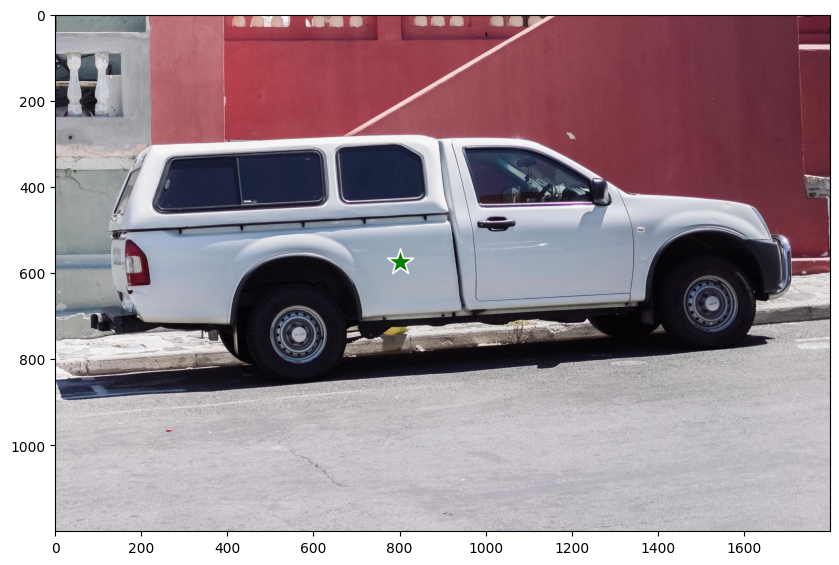

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [17]:
thres_upscaled_masks = upscaled_masks > 0.0

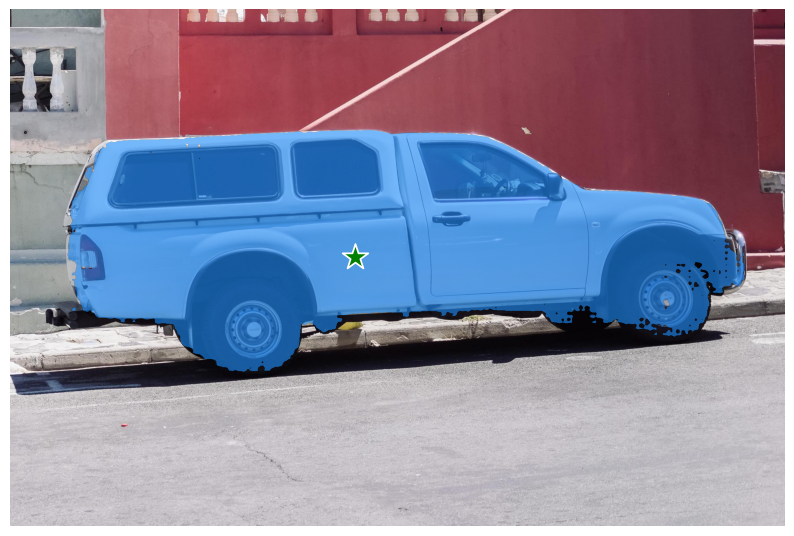

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(thres_upscaled_masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 